In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse
import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory

In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
def get_data(granularity, instrument, save_csv=False):
    client = API(access_token="e11aadc917842adf254cd73c038c4e0a-321ea21ac5697ab46036807f5e5e943d")
    

    params = {

        "granularity": granularity,
        "count": 3000,
     }
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
            rv = client.request(r)
            results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                        "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                       "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                       } for candle in r.response.get('candles')]
            df = df.append(pd.DataFrame(results), ignore_index=True)

    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
df = get_data(instrument = "NAS100_USD", granularity = "D", save_csv = False)
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-03-03T22:00:00,14062.8,14082.2,13730.2,13796.5,895524.0
2022-03-06T22:00:00,13725.6,13875.1,13261.2,13267.8,956877.0
2022-03-07T22:00:00,13257.2,13661.7,13100.2,13196.6,1363429.0
2022-03-08T22:00:00,13194.0,13817.3,13188.4,13771.0,954322.0
2022-03-09T22:00:00,13760.2,13770.9,13722.7,13743.2,27337.0


In [5]:
import talib as ta
from talib import MA_Type

def generate_features(df):

    df_new = pd.DataFrame()
    
    # rolling mean ist das Beste Feature für SVM!
    
    df_new['Close'] = df['Close'].rolling(window=9).mean() 
    df_new['Close2'] = df['Close']
    df_new['Open'] = df['Open'].rolling(window=9).mean() 
    df_new['High'] = df['High'].rolling(window=9).mean()  
    df_new['Low'] = df['Low'].rolling(window=9).mean()    
    df_new['Volume'] = df['Volume'].rolling(window=9).mean()    
    df_new['MFI_5'] = ta.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=9)
    
    df_new['High-Low'] = df['High'] - df['Close']
    df_new['CCI1'] = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=9)
    df_new['ADX'] = ta.ADX(df['High'], df['Low'], df['Close'], timeperiod=9)
    df_new['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=9)
    df_new['OBV'] = ta.OBV(df['Close'], df['Volume'])
    
   

    
  
    df_new = df_new.dropna(axis=0)
    return df_new

In [6]:
df = generate_features(df)
df.tail()

,Close,Close2,Open,High,Low,Volume,MFI_5,High-Low,CCI1,ADX,ATR,OBV
Date,,,,,,,,,,,,
2022-03-03T22:00:00,13976.800000,13796.5,13903.200000,14191.900000,13666.888889,1.010951e+06,63.987073,285.7,-31.283894,37.219981,469.432564,6265254.0
2022-03-06T22:00:00,13904.133333,13267.8,13916.088889,14165.866667,13631.200000,1.001355e+06,53.229440,607.3,-136.738351,39.045497,485.484501,5308377.0
2022-03-07T22:00:00,13872.000000,13196.6,13841.666667,14120.566667,13589.800000,1.083257e+06,49.437686,465.1,-140.533680,41.149851,493.930668,3944948.0
2022-03-08T22:00:00,13856.377778,13771.0,13809.033333,14102.266667,13608.022222,9.885982e+05,64.668366,46.3,-66.557138,41.400107,508.927260,4899270.0
2022-03-09T22:00:00,13807.366667,13743.2,13792.688889,14055.188889,13603.966667,8.759606e+05,60.040943,27.7,-19.746959,41.622557,457.746454,4871933.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2983 entries, 2010-10-25T21:00:00 to 2022-03-09T22:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     2983 non-null   float64
 1   Close2    2983 non-null   float64
 2   Open      2983 non-null   float64
 3   High      2983 non-null   float64
 4   Low       2983 non-null   float64
 5   Volume    2983 non-null   float64
 6   MFI_5     2983 non-null   float64
 7   High-Low  2983 non-null   float64
 8   CCI1      2983 non-null   float64
 9   ADX       2983 non-null   float64
 10  ATR       2983 non-null   float64
 11  OBV       2983 non-null   float64
dtypes: float64(12)
memory usage: 303.0+ KB


In [8]:
df.head()

,Close,Close2,Open,High,Low,Volume,MFI_5,High-Low,CCI1,ADX,ATR,OBV
Date,,,,,,,,,,,,
2010-10-25T21:00:00,2090.477778,2119.6,2083.422222,2103.388889,2069.977778,10526.666667,64.529526,4.2,123.252364,33.978035,33.151331,99808.0
2010-10-26T21:00:00,2095.933333,2122.3,2090.266667,2109.344444,2076.677778,10406.111111,64.221566,4.5,108.574497,34.596078,32.001183,109708.0
2010-10-27T21:00:00,2099.644444,2131.8,2095.777778,2113.577778,2082.077778,10184.333333,63.521735,6.2,110.560345,35.971810,31.445496,119877.0
2010-10-28T21:00:00,2106.544444,2125.2,2099.600000,2117.011111,2088.622222,10006.333333,74.056898,12.0,88.403449,37.194683,30.029330,111368.0
2010-10-31T21:00:00,2113.366667,2129.9,2106.700000,2123.822222,2095.666667,9443.333333,89.625679,18.2,97.011814,39.056869,30.159404,121033.0


In [9]:
# hier bei sigma muss ich noch herumprobieren. aber das macht auch einen Unterschied.
# C ist für die Regulierung und Gamma für den Einfluss einer einzelnen Trainingseinheit
# Gamma ist sehr wichtig, wichtiger als C

sigma = 11
gamma = 1/(2 * sigma **2)

Indikatoren = df[['ADX',  'CCI1']]

Y = np.where(df['Close'].shift(-3) > df['Close'],1,-1)
X = Indikatoren

split_percentage = 0.7
split = int(split_percentage*len(df))

# Train data set
X_train = X[:split]
Y_train = Y[:split]

# Test data set
X_test = X[split:]
Y_test = Y[split:]
#print(Df)
cls = SVC(kernel = 'rbf', gamma = gamma, C = 5, decision_function_shape = 'ovr').fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, cls.predict(X_train))
accuracy_test = accuracy_score(Y_test, cls.predict(X_test))

print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 84.53%
Test Accuracy: 82.91%


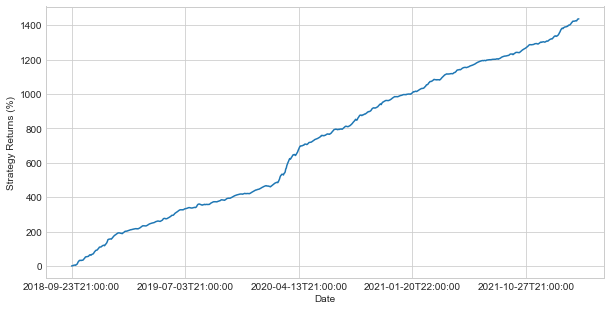

In [10]:
# Backtest 1

df['Predicted_Signal'] = cls.predict(X)
# Calculate log returns
df['Return'] = np.log(df.Close2.shift(-1) / df.Close)*100
df['Strategy_Return'] = df.Return * df.Predicted_Signal
df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

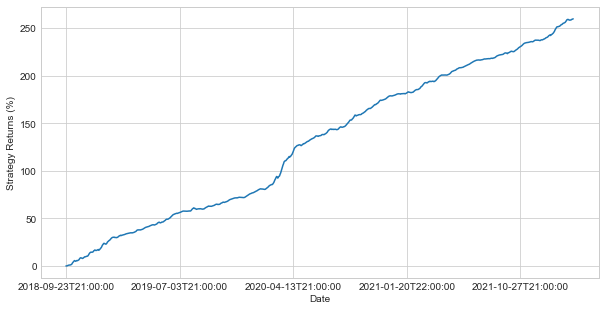

In [11]:
# Backtest 2

df['Predicted_Signal'] = cls.predict(X)
# Calculate log returns
df['Return'] = np.log(df.Close.shift(-1) / df.Close)*100
df['Strategy_Return'] = df.Return * df.Predicted_Signal
df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

In [12]:

X= Indikatoren[-1:]
position = int(cls.predict(X))

In [13]:
print(position)

1


<AxesSubplot:xlabel='Date'>

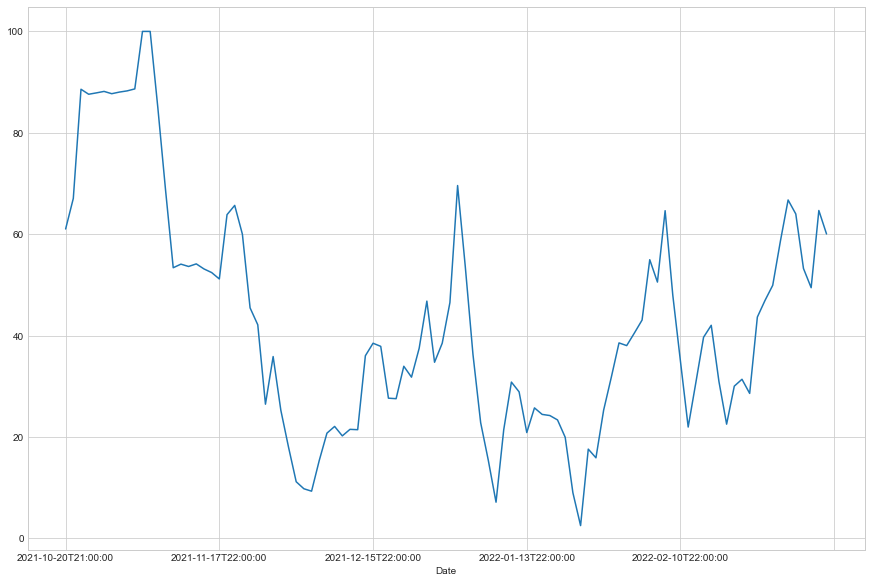

In [14]:
df['MFI_5'][-100:].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

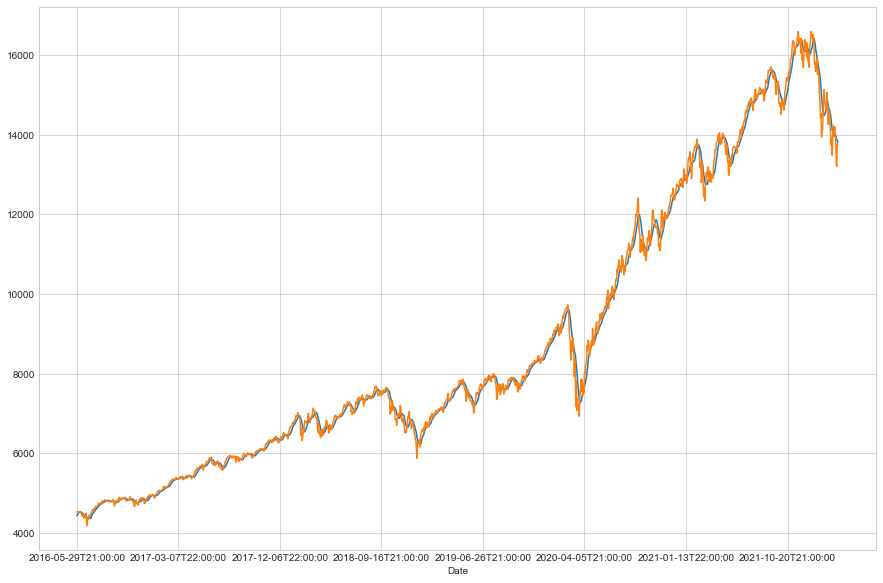

In [19]:
df['Close'][-1500:].plot(figsize=(15,10))
df['Close2'][-1500:].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

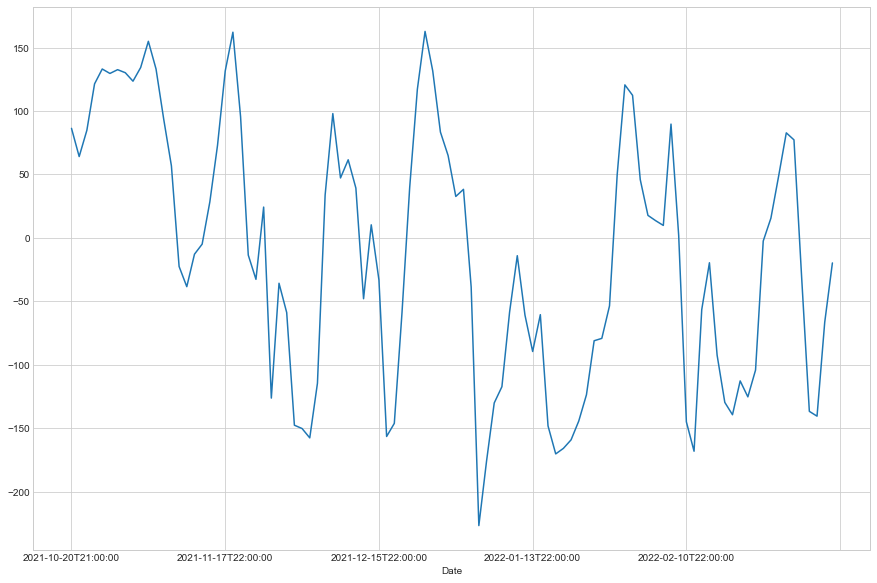

In [16]:
#df['CCI2'][-500:].plot(figsize=(15,10))
df['CCI1'][-100:].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

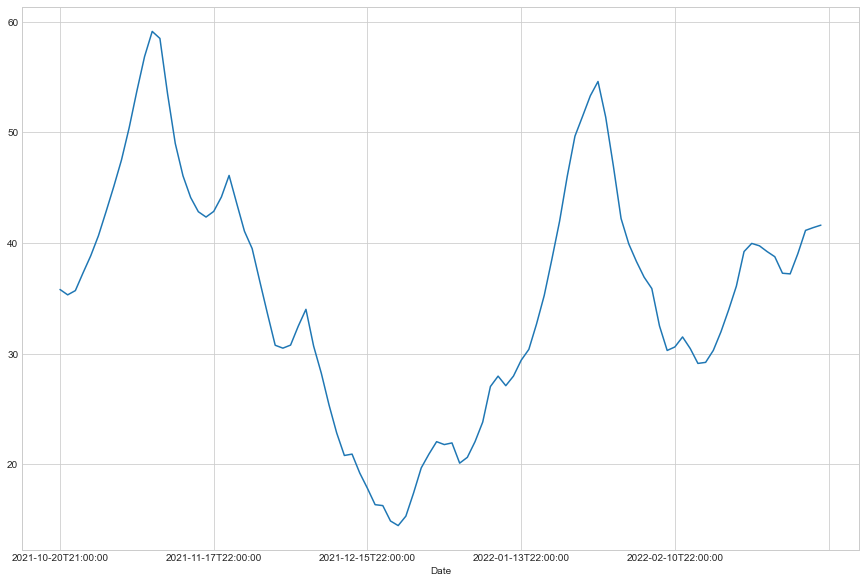

In [17]:
df['ADX'][-100:].plot(figsize=(15,10))

##### 

<AxesSubplot:xlabel='Date'>

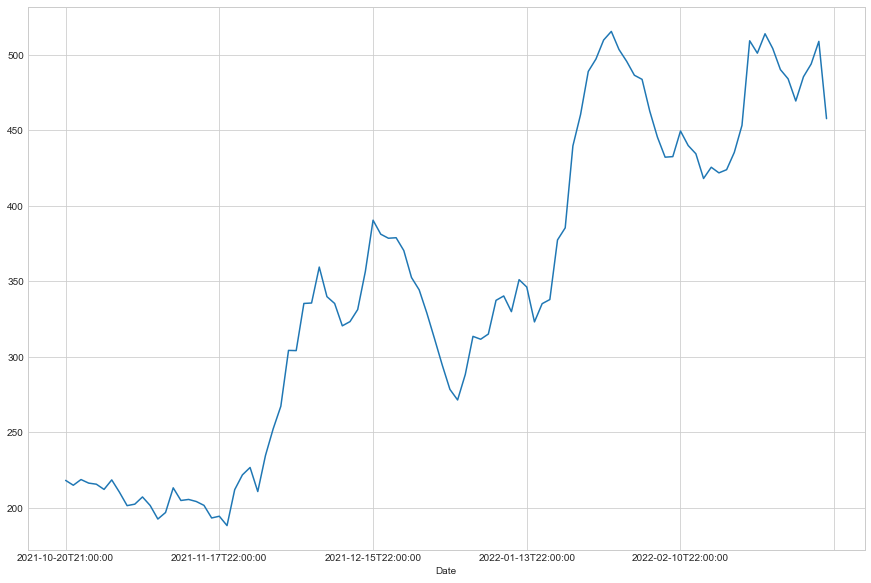

In [18]:
df['ATR'][-100:].plot(figsize=(15,10))